In [2]:
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, current_dir)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import argparse
import time
import os
import copy
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from tensorboardX import SummaryWriter
from tqdm import tqdm

print(sys.path)

from models.model_RCNN_only import RCNN_only
from utils.compute_vectors import generate_field
from maskrcnn_rui.data.transforms import build_transforms_maskrcnn, build_transforms_yannick

from maskrcnn_rui.config import cfg

import utils.model_utils as model_utils
from utils.logger import setup_logger, printer
from utils.train_utils import *
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
from utils.checkpointer import DetectronCheckpointer

import maskrcnn_benchmark

from utils.utils_misc import *

parser = argparse.ArgumentParser(description="Rui's Scale Estimation Network Training")
# Training
parser.add_argument('--task_name', type=str, default='tmp', help='resume training')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=8)
parser.add_argument('--batchsize', type=int, default=36, help='input batch size during training')
parser.add_argument('--save_every_iter', type=int, default=0, help='set to 0 to save ONLY at the end of each epoch')
# parser.add_argument('--batchsizeeval', type=int, default=42, help='input batch size during evaluation')
parser.add_argument('--niter', type=int, default=5000, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate, default=0.005')
parser.add_argument('--beta1', type=float, default=0.9, help='beta1 for adam. default=0.5')
parser.add_argument('--not_val', action='store_true', help='Do not validate duruign training')
parser.add_argument('--save_every_epoch', type=int, default=10, help='save checkpoint every ? epoch')
# Model
parser.add_argument('--accu_model', action='store_true', help='Use accurate model with theta instead of Derek\'s approx.')
# Pretraining
parser.add_argument('--resume', type=str, help='resume training; can be full path (e.g. tmp/checkpoint0.pth.tar) or taskname (e.g. tmp)', default='NoCkpt')
parser.add_argument('--feature_only', action='store_true', help='restore only features (remove all classifiers) from checkpoint')
# Device
parser.add_argument('--cpu', action='store_true', help='Force training on CPU')
parser.add_argument("--local_rank", type=int, default=0)
parser.add_argument("--master_port", type=str, default='8914')
# DEBUG
parser.add_argument('--debug', action='store_true', help='Debug eval')
# Mask R-CNN
parser.add_argument('--not_rcnn', action='store_true', help='Disable Mask R-CNN module')

parser.add_argument('--pointnet_camH', action='store_true', help='')
parser.add_argument('--est_bbox', action='store_true', help='Enable estimating bboxes instead of using GT bboxes')

parser.add_argument(
    "--config-file",
    default="",
    metavar="FILE",
    help="path to config file",
    type=str,
)
parser.add_argument(
    "opts",
    help="Modify config options using the command-line",
    default=None,
    nargs=argparse.REMAINDER,
)

# opt = parser.parse_args()
opt = parser.parse_args('--batchsize=1 --task_name tmp_eval --niter 1 --accu_model --resume YES \
--config-file coco_config_small_RCNNOnly.yaml \
SOLVER.IMS_PER_BATCH 1 TEST.IMS_PER_BATCH 1'.split())

opt.checkpoints_folder = 'checkpoint'

# config_file = "maskrcnn/coco_config.yaml"
config_file = opt.config_file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cuda"])
cfg.merge_from_list(opt.opts)
cfg.freeze()
opt.cfg = cfg

# === DISTRIBUTED TRAINING
num_gpus = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
opt.distributed = num_gpus > 1
if opt.distributed:
    torch.cuda.set_device(opt.local_rank)
    torch.distributed.init_process_group(
        backend="nccl", init_method="env://"
    )
    synchronize()
# device = torch.device("cuda" if torch.cuda.is_available() and not opt.cpu else "cpu")
device = 'cuda'
print("Device:", device)
rank = get_rank()

# === SUMMARY WRITERS
summary_path = './summary/'+opt.task_name
writer = SummaryWriter(summary_path)

# === LOGGING
# sys.stdout = Logger(summary_path+'/log.txt')
logger = setup_logger("logger:train", summary_path, get_rank(), filename="logger_maskrcn-style.txt")
logger.info(colored("==[config]== opt", 'white', 'on_blue'))
logger.info(opt)
logger.info(colored("==[config]== cfg", 'white', 'on_blue'))
logger.info(cfg)
logger.info(colored("==[config]== Loaded configuration file {}".format(opt.config_file), 'white', 'on_blue'))
with open(opt.config_file, "r") as cf:
    config_str = "\n" + cf.read()
    logger.info(config_str)
printer = printer(get_rank(), debug=opt.debug)

['/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/RELEASE_ScaleNet/RELEASE_SUN360_camPred_minimal', '/home/ruizhu/anaconda3/envs/scalenet/lib/python36.zip', '/home/ruizhu/anaconda3/envs/scalenet/lib/python3.6', '/home/ruizhu/anaconda3/envs/scalenet/lib/python3.6/lib-dynload', '', '/home/ruizhu/.local/lib/python3.6/site-packages', '/home/ruizhu/anaconda3/envs/scalenet/lib/python3.6/site-packages', '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/RELEASE_ScaleNet/RELEASE_SUN360_camPred_minimal/maskrcnn-benchmark', '/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/RELEASE_ScaleNet/RELEASE_SUN360_camPred_minimal', '/home/ruizhu/anaconda3/envs/scalenet/lib/python3.6/site-packages/apex-0.1-py3.6-linux-x86_64.egg', '/home/ruizhu/anaconda3/envs/scalenet/lib/python3.6/site-packages/IPython/extensions', '/home/ruizhu/.ipython']
[data-SUN360] Narrower in DS_ROOT:data/SUN360_mini_crops_dataset_cvpr_myDistNarrowerLarge1105
Device: cuda
logger:

logger:train INFO: ==[config]== Loaded configuration file coco_config_small_RCNNOnly.yaml
logger:train INFO: 
# Based on https://github.com/facebookresearch/maskrcnn-benchmark/blob/464b1af167d3dcb513964e62389825ff507609c3/configs/e2e_faster_rcnn_fbnet_chamv1a_600.yaml

MODEL:
  META_ARCHITECTURE: "GeneralizedRCNNRui"
#  RCNN_WEIGHT: "/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/pretrained/e2e_faster_rcnn_fbnet_chamv1a_600.pth"
  RCNN_WEIGHT_BACKBONE: "/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/pretrained/e2e_faster_rcnn_fbnet_chamv1a_600.pth"
#  RCNN_WEIGHT_BACKBONE: "1105Morning-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDist_fix_bs16on4_le5e-3_unfreeezeFeat_indeptClsHeads"
  RCNN_WEIGHT_BOX_HEAD: "/home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/maskrcnn/pretrained/e2e_faster_rcnn_fbnet_chamv1a_600.pth"
#  RCNN_WEIGHT_BOX_HEAD: "1105Morning-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDist_fix_bs16on4_le5e-3_

In [6]:
resume_task_name = '1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug'

model = RCNN_only(cfg, opt, logger, printer, rank=rank)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=cfg.SOLVER.BASE_LR, betas=(opt.beta1, 0.999), eps=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=20, cooldown=10)

save_to_disk = get_rank() == 0
opt.checkpoints_folder = 'checkpoint'
checkpointer = DetectronCheckpointer(
    opt, model, optimizer, scheduler, opt.checkpoints_folder, os.path.join(opt.checkpoints_folder, resume_task_name), save_to_disk, logger=logger
)
checkpoint_restored, _, _ = checkpointer.load(task_name=resume_task_name)

# === DATASET
train_trnfs_maskrcnn = build_transforms_maskrcnn(cfg, True)
eval_trnfs_maskrcnn = build_transforms_maskrcnn(cfg, False)

logger:train INFO: Using 'latest checkpoint' from task 1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug...; at /home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18/checkpoint/1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug/checkpointer_epoch0055_iter0136785.pth
logger:train INFO: Loading checkpoint from /home/ruizhu/Documents/Projects/adobe_rui_camera-calibration-redux/adobe_camera_calibration_cvpr18/checkpoint/1109-0141-mm1_SUN360RCNN-HorizonPitchRollVfovNET_myDistNarrowerLarge1105_bs16on4_le1e-5_indeptClsHeads_synBNApex_valBS1_yannickTransformAug/checkpointer_epoch0055_iter0136785.pth.
logger:train WARNING: ====== current_keys 621; loaded keys 601
logger:train WARNING: RCNN.backbone.body.first.bn.bias                                                           

logger:train WARNING: RCNN.backbone.body.stages.xif1_0.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif1_0.pwl.bn.running_mean                                                     of shape (48,)
logger:train WARNING: RCNN.backbone.body.stages.xif1_0.pwl.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif1_0.pwl.bn.running_var                                                      of shape (48,)
logger:train WARNING: RCNN.backbone.body.stages.xif1_0.pwl.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif1_0.pwl.bn.weight                                                           of shape (48,)
logger:train WARNING: RCNN.backbone.body.stages.xif1_0.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif1_0.pwl.conv.weight                    

logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pw.bn.bias                                                              of shape (448,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pw.bn.num_batches_tracked                                               <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pw.bn.num_batches_tracked                                               of shape ()
logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pw.bn.running_mean                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pw.bn.running_mean                                                      of shape (448,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_1.pw.bn.running_var                                                       <<LOADED FROM<< RCNN.backbone.body.stages.xif2_1.pw.bn.running_var                   

logger:train WARNING: RCNN.backbone.body.stages.xif2_3.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif2_3.pw.conv.weight                                                          of shape (448, 64, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif2_3.pwl.bn.bias                                                             <<LOADED FROM<< RCNN.backbone.body.stages.xif2_3.pwl.bn.bias                                                             of shape (64,)
logger:train WARNING: RCNN.backbone.body.stages.xif2_3.pwl.bn.num_batches_tracked                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif2_3.pwl.bn.num_batches_tracked                                              of shape ()
logger:train WARNING: RCNN.backbone.body.stages.xif2_3.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif2_3.pwl.bn.running_mean         

logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pwl.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pwl.bn.weight                                                           of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_0.pwl.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_0.pwl.conv.weight                                                         of shape (56, 768, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_1.dw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif3_1.dw.conv.weight                                                          of shape (672, 1, 5, 5)
logger:train WARNING: RCNN.backbone.body.stages.xif3_1.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_1.pw.bn.bias      

logger:train WARNING: RCNN.backbone.body.stages.xif3_11.pw.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_11.pw.bn.running_mean                                                     of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_11.pw.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_11.pw.bn.running_var                                                      of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_11.pw.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif3_11.pw.bn.weight                                                           of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_11.pw.conv.weight                                                         <<LOADED FROM<< RCNN.backbone.body.stages.xif3_11.pw.conv.weight                 

logger:train WARNING: RCNN.backbone.body.stages.xif3_3.pwl.bn.num_batches_tracked                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_3.pwl.bn.num_batches_tracked                                              of shape ()
logger:train WARNING: RCNN.backbone.body.stages.xif3_3.pwl.bn.running_mean                                                     <<LOADED FROM<< RCNN.backbone.body.stages.xif3_3.pwl.bn.running_mean                                                     of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_3.pwl.bn.running_var                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_3.pwl.bn.running_var                                                      of shape (56,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_3.pwl.bn.weight                                                           <<LOADED FROM<< RCNN.backbone.body.stages.xif3_3.pwl.bn.weight                         

logger:train WARNING: RCNN.backbone.body.stages.xif3_6.dw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.dw.conv.weight                                                          of shape (672, 1, 5, 5)
logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pw.bn.bias                                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pw.bn.bias                                                              of shape (672,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pw.bn.num_batches_tracked                                               <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pw.bn.num_batches_tracked                                               of shape ()
logger:train WARNING: RCNN.backbone.body.stages.xif3_6.pw.bn.running_mean                                                      <<LOADED FROM<< RCNN.backbone.body.stages.xif3_6.pw.bn.running_mean          

logger:train WARNING: RCNN.backbone.body.stages.xif3_8.pw.bn.weight                                                            <<LOADED FROM<< RCNN.backbone.body.stages.xif3_8.pw.bn.weight                                                            of shape (704,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_8.pw.conv.weight                                                          <<LOADED FROM<< RCNN.backbone.body.stages.xif3_8.pw.conv.weight                                                          of shape (704, 88, 1, 1)
logger:train WARNING: RCNN.backbone.body.stages.xif3_8.pwl.bn.bias                                                             <<LOADED FROM<< RCNN.backbone.body.stages.xif3_8.pwl.bn.bias                                                             of shape (88,)
logger:train WARNING: RCNN.backbone.body.stages.xif3_8.pwl.bn.num_batches_tracked                                              <<LOADED FROM<< RCNN.backbone.body.stages.xif3_8.pwl.bn.num_batches_track

logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.running_var         <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.running_var         of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.weight              <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.bn.weight              of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.conv.weight            <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_0.pwl.conv.weight            of shape (152, 616, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_1.dw.conv.weight             <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extrac

logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.num_batches_tracked  <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.num_batches_tracked  of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean         <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_mean         of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_var          <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.running_var          of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blocks.xif4_3.pw.bn.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_horizon.feature_extractor.head.blo

logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.bn.weight                 <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.bn.weight                 of shape (616,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pw.conv.weight               of shape (616, 88, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pwl.bn.bias                  <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pwl.bn.bias                  of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_0.pwl.bn.num_batches_tracked   <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor

logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var           <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.running_var           of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.bn.weight                of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.conv.weight              <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_2.pwl.conv.weight              of shape (152, 1064, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_pitch.feature_extractor.head.blocks.xif4_3.dw.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_pitch.feature_extract

logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.dw.conv.weight                of shape (616, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.pw.bn.bias                    <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.pw.bn.bias                    of shape (616,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.pw.bn.num_batches_tracked     <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.pw.bn.num_batches_tracked     of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_0.pw.bn.running_mean            <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.

logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.bn.weight                  of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pw.conv.weight                of shape (1064, 152, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pwl.bn.bias                   <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pwl.bn.bias                   of shape (152,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_2.pwl.bn.num_batches_tracked    <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extract

logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.pwl.bn.running_var            <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.pwl.bn.running_var            of shape (104,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.pwl.bn.weight                 <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.pwl.bn.weight                 of shape (104,)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.pwl.conv.weight               <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.feature_extractor.head.blocks.xif4_4.pwl.conv.weight               of shape (104, 1520, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_roll.predictor.cls_score.bias                                           <<LOADED FROM<< RCNN.classifier_heads.classifier_roll.predictor.cls_sc

logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.dw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.dw.conv.weight                of shape (1064, 1, 3, 3)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pw.bn.bias                    <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pw.bn.bias                    of shape (1064,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pw.bn.num_batches_tracked     <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pw.bn.num_batches_tracked     of shape ()
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_2.pw.bn.running_mean            <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.hea

logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.bn.weight                  <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.bn.weight                  of shape (1520,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.conv.weight                <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pw.conv.weight                of shape (1520, 152, 1, 1)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pwl.bn.bias                   <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pwl.bn.bias                   of shape (104,)
logger:train WARNING: RCNN.classifier_heads.classifier_vfov.feature_extractor.head.blocks.xif4_4.pwl.bn.num_batches_tracked    <<LOADED FROM<< RCNN.classifier_heads.classifier_vfov.feature_extract

# Test on single image

In [7]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from PIL import Image
from dataset_cvpr import bins2roll, bins2vfov, bins2horizon, bins2pitch

def showHorizonLine(image, vfov, pitch, roll, focal_length=-1, color=(0, 255, 0), width=5, debug=False, GT=False):
    """
    Angles should be in radians.
    """
    h, w, c = image.shape
    if image.dtype in (np.float32, np.float64):
        image = (image * 255).astype('uint8')

    if debug:
        if GT == False:
            image[0:12,:,:] = 0
        else:
            image[h-12:h,:,:] = 0

    im = Image.fromarray(image)
    draw = ImageDraw.Draw(im)

    ctr = h*( 0.5 - 0.5*np.tan(pitch) / np.tan(vfov/2) )
    l = ctr - w*np.tan(roll)/2
    r = ctr + w*np.tan(roll)/2
    if debug:
        if GT == False:
            draw.text((0, 0), "vfov:{0:.2f}, pitch:{1:.2f}, roll:{2:.2f}, f_mm:{3:.2f}".format(vfov*180/np.pi, pitch*180/np.pi, roll*180/np.pi, focal_length), (255, 255, 255))
        else:
            draw.text((0, h-12), "GT: vfov:{0:.2f}, pitch:{1:.2f}, roll:{2:.2f}, f_mm:{3:.2f}".format(vfov*180/np.pi, pitch*180/np.pi, roll*180/np.pi, focal_length), (255, 255, 255))

    draw.line((0, l, w, r), fill=color, width=width)
    return np.array(im), ctr/h

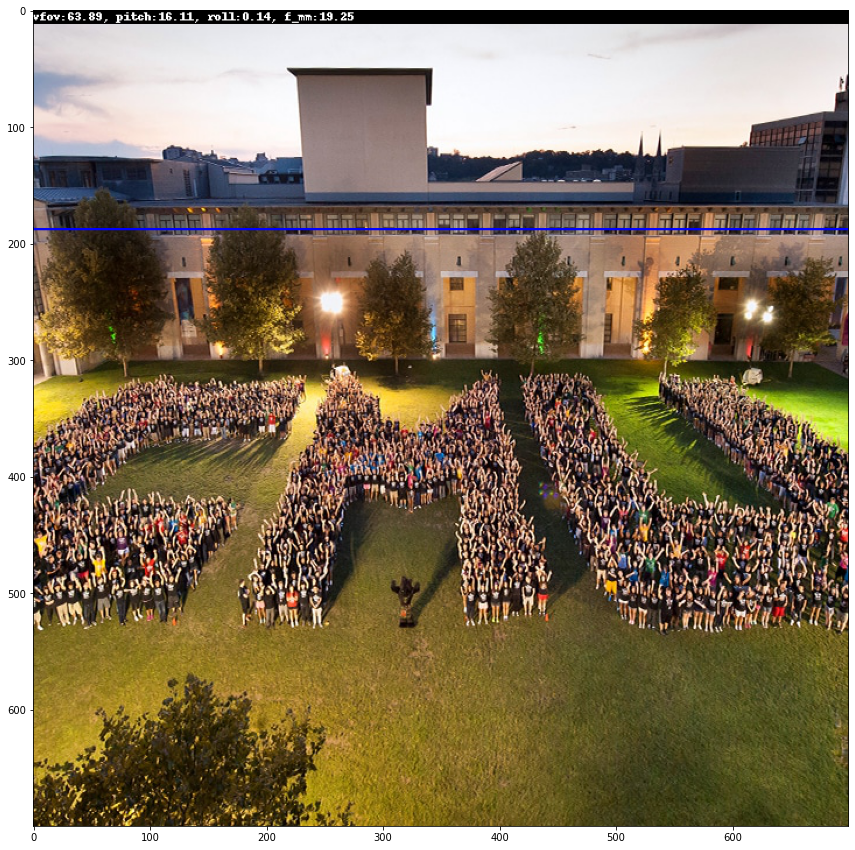

In [9]:
model.eval() #很关键！

test_image_path = 'demo/fall-cmu-700x700.jpg'
# test_image_path = 'demo/white-house.jpg'
im_ori_RGB = Image.open(test_image_path).convert('RGB') #im_ori_RGB.size: [W, H]
im = eval_trnfs_maskrcnn(im_ori_RGB)
        
H_num, W_num = im_ori_RGB.size
list_of_oneLargeBbox_list_cpu = model_utils.oneLargeBboxList([W_num], [H_num])
list_of_oneLargeBbox_list = [bbox_list_array.to(device) for bbox_list_array in list_of_oneLargeBbox_list_cpu]

output_RCNN = model(image_batch_list=[im.to(device)], list_of_oneLargeBbox_list=list_of_oneLargeBbox_list)
output_horizon = output_RCNN['output_horizon']
output_pitch = output_RCNN['output_pitch']
output_roll = output_RCNN['output_roll']
output_vfov = output_RCNN['output_vfov']

idx = 0

im = im_ori_RGB
if len(im.getbands()) == 1:
    im = Image.fromarray(np.tile(np.asarray(im)[:,:,np.newaxis], (1, 1, 3)))

horizon_disc = output_horizon[idx].detach().cpu().numpy().squeeze()
pitch_disc = output_pitch[idx].detach().cpu().numpy().squeeze()
roll_disc = output_roll[idx].detach().cpu().numpy().squeeze()
vfov_disc = output_vfov[idx].detach().cpu().numpy().squeeze()
# distortion_disc = distortion_disc.detach().cpu().numpy().squeeze()
vfov_disc[...,0] = -35
vfov_disc[...,-1] = -35

horizon = bins2horizon(horizon_disc)
pitch = bins2pitch(pitch_disc)
roll = bins2roll(roll_disc)
vfov = bins2vfov(vfov_disc)
w, h = im.size
f_pix = h / 2. / np.tan(vfov / 2.)
# sensor_size = sensor_size_num[idx]
sensor_size = 24 # !!!!!!
f_mm = f_pix / h * sensor_size
# print(sensor_size)

im2, _ = showHorizonLine(np.asarray(im).copy(), vfov, pitch, roll, focal_length=f_mm, debug=True, color=(0, 0, 255), width=3) # Blue: horizon converted from camera params with roll

plt.figure(figsize=(15, 15))
plt.imshow(im2)
plt.show()
plt.close()

In [13]:
im.size

(1920, 720)